In [1]:
import sys


sys.path.append('../common_code')

# # for reading datafiles 
import pandas as pd
# import script that has many standard functions:
from PostProcessingScripts import * 

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


obtain index of the SFRD models that we want to highlight


/var/folders/lc/vg4hc2nn2pn05y4lw3h5wmpm0000gn/T/ipykernel_25770/3290726233.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:

# GWTC-1, GWTC-2.1, GWTC-3
BBH_list = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729', 'GW170809', 'GW170814', 'GW170818', 'GW170823', 'GW190403_051519', 'GW190408_181802', 'GW190412', 'GW190413_052954', 'GW190413_134308', 'GW190421_213856', 'GW190426_190642', 'GW190503_185404', 'GW190512_180714', 'GW190513_205428', 'GW190514_065416', 'GW190517_055101', 'GW190519_153544', 'GW190521', 'GW190521_074359', 'GW190527_092055', 'GW190602_175927', 'GW190620_030421', 'GW190630_185205', 'GW190701_203306', 'GW190706_222641', 'GW190707_093326', 'GW190708_232457', 'GW190719_215514', 'GW190720_000836', 'GW190725_174728', 'GW190727_060333', 'GW190728_064510', 'GW190731_140936', 'GW190803_022701', 'GW190805_211137', 'GW190814', 'GW190828_063405', 'GW190828_065509', 'GW190910_112807', 'GW190915_235702', 'GW190916_200658', 'GW190917_114630', 'GW190924_021846', 'GW190925_232845', 'GW190926_050336', 'GW190929_012149', 'GW190930_133541', 'GW191103_012549', 'GW191105_143521', 'GW191109_010717', 'GW191113_071753', 'GW191126_115259', 'GW191127_050227', 'GW191129_134029', 'GW191204_110529', 'GW191204_171526', 'GW191215_223052', 'GW191216_213338', 'GW191222_033537', 'GW191230_180458', 'GW200112_155838', 'GW200128_022011', 'GW200129_065458', 'GW200202_154313', 'GW200208_130117', 'GW200208_222617', 'GW200209_085452', 'GW200210_092255', 'GW200216_220804', 'GW200219_094415', 'GW200220_061928', 'GW200220_124850', 'GW200224_222234', 'GW200225_060421', 'GW200302_015811', 'GW200306_093714', 'GW200308_173609', 'GW200311_115853', 'GW200316_215756', 'GW200322_091133']

BNS_list = ['GW170817', 'GW190425']

BHNS_list = ['GW190426_152155', 'GW190917_114630', 'GW200105', 'GW200115']


print(len(BBH_list), len(BBH_list)-10)

86 76


Movie shows the growth and expected growth of the number of gravitational-wave detections from 2015 to 2040. 
The colors show BH-BH (black lines), BH-NS (green), and NS-NS (orange) detections. Solid lines show current detections, whereas dashed lines shows expected rates (which are still uncertain and depend on the detector configuration, and source properties). 


Data:
in 2015: first BH-BH, and a total of 3 BH-BHs (see GWTC-1 https://arxiv.org/abs/1811.12907)
by the end of 2017: seven more BH-BHs (now a total of 10 BH-BH), and the first NS-NS (source: GWTC-2; https://arxiv.org/abs/2010.14527, updated with GWTC-2.1; https://arxiv.org/abs/2108.01045)
in 2019-2020: 76 more BH-BH, now a total of 86 BH-BH in the catalog, 1 more NS-NS (now a total of 2 NS-NS in the catalog), 3 BH-NS (source GWTC-3 https://arxiv.org/abs/2111.03606)
    
This means that the current fraction of each DCO flavor in the total *detections* is approximate: 
BH-BH: 86/91
BH-NS: 3/91
NS-NS: 2/91

We will use these fractions to calculate the detector expectations for observations post O3 
For O4 we use a 1.5 year observing time, and about 2x more detections than O3 (so 180 BBHs= 2x90) based on https://observing.docs.ligo.org/plan/ 
For O5 we use a 2 year observation span, and again about 8x more total detections than O3 (BBH = 8x 90)
For Voyager, we use 4 year timeline, and about 100x more total detections compared to O3  (BBH = 100x 90) on https://arxiv.org/pdf/2001.11173.pdf
For Cosmic Explorer (CE) and  Einstein Telescope (ET) we use a timeline of 5 years, and detection of about 600 000 BBH per year, found from https://arxiv.org/abs/2207.02771



In [109]:
import datetime 
import matplotlib.dates as mdates
from datetime import date

fmt = 'GW%y%m%d'


GW_ = ['GW190521']


# _%H%M%S
trystr = '190521'



strptime_BBHs = []
for GW_ in BBH_list:
    
    d2 = datetime.datetime.strptime(GW_.split('_')[0], fmt)
    d2 = d2.year + d2.month/12.
    strptime_BBHs.append(d2)
       
strptime_BHNSs = []
for GW_ in BHNS_list:
    
    d2 = datetime.datetime.strptime(GW_.split('_')[0], fmt)
    d2 = d2.year + d2.month/12.
    strptime_BHNSs.append(d2)    


strptime_BNSs = []
for GW_ in BNS_list:
    
    d2 = datetime.datetime.strptime(GW_.split('_')[0], fmt)
    d2 = d2.year + d2.month/12.
    strptime_BNSs.append(d2)  
    
    
    
    
today = datetime.datetime.now()

# days passed since beginning of year
d0 = date(2023, 1, 1)
d1 = date(today.year, today.month, today.day)
delta = d1 - d0

# find today, use -1 to correct for that it starts at 0 
today = today.year  + (delta.days-1)/356.
print(today)





2023.2191011235955


In [111]:
def cumhist(data, reverse=False, mark=None, ax=None, **kwargs):
    """
    Plot a cumulative histogram of `data`, optionally with certain indices marked with an x.

    Parameters
    ----------
    data : array-like
        Data to include in the histogram
    reverse : bool, optional
        If False (default), the histogram increases with increasing `data`. If True, it decreases with increasing `data`
    mark : array-like, optional
        An array of indices to mark with an x
    ax : matplotlib.pyplot.axes, optional
        Axis on which to plot the confusion matrix. Default: current axis.
    kwargs : dict, optional
        Keyword arguments to be passed to `matplotlib.pyplot.step`

    Returns
    -------
    p : list
        The list of `matplotlib.lines.Line2D` objects returned by `matplotlib.pyplot.step`
    """
    if mark is None:
        mark = np.zeros(len(data), bool)
    if ax is None:
        ax = plt.gca()
    i = np.argsort(data)
    x = data[i]
    mark = mark[i]
    x = np.append(x, x[-1])
    y = np.linspace(0., x.size, x.size) -1
    if reverse:
        y = y[::-1]
    p = ax.step(x, y, **kwargs)
    ax.scatter(data[i][mark], (y[:-1] + 0.5 * np.diff(y))[mark], marker='x')
    return p






def find_position_plot(year):
    
    position  = (year-2014)/(2040-2014)
    return position



def plot_detector_labels(axe):
    labels = [r'$\textbf{O1}$', r'$\textbf{O2}$', r'$\textbf{O3}$',  r'$\textbf{O4}$',  r'$\textbf{O5}$',  r'$\textbf{Voyager}$',   r'$\textbf{CE/ET}$'] # r'$\textbf{next-gen:}$' +'\n' + r'$\textbf{CE/ET}$' ]
    label_centers = [2015.9, 2017.45, 2019.78, 2024.26, 2027, 2032., 2037.3]
    for ind_year, year in enumerate(label_centers):
        position = find_position_plot(year)
        axe.text(position, 1-0.009, labels[ind_year] , rotation = 0, fontsize = fs+10, color = 'k', ha = 'center', va='top', transform=axe.transAxes, zorder=100)#, weight = 'bold')




In [112]:

## BBH 
n_O4 = 180
numberO3end = len(strptime_BBHs) # number BBHs at end of O3
numberO4end = numberO3end + n_O4 # O4 has about twice as many BBHs as O3  (180 = 2x90)
numberO5end = numberO4end + 4*n_O4 # O5 has about twice as many BBHs as O3  (180 = 2x90)
numbersVoyend = numberO5end + 50*n_O4 # based on the factor 100 compared to O3, from https://arxiv.org/pdf/2001.11173.pdf  (which is a factor 50 compared to O4)
numbersCEend = numbersVoyend + 3.5*1E3*n_O4 * 5 # CE will detect about 600 000 events BBH per year, see https://arxiv.org/abs/2207.02771 , factor 5 for the timeline (that is already included in the other ones)
numbers_BBH = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]


## BHNS
fraction_BHNS =  3/91. 
numberO3end = len(strptime_BHNSs) # number BBHs at end of O3
numberO4end = numberO3end + n_O4*(fraction_BHNS)
numberO5end = numberO4end + 4*n_O4*(fraction_BHNS)
numbersVoyend = numberO5end + 50*n_O4*(fraction_BHNS)
numbersCEend = numbersVoyend + 3.5*1E3*n_O4*(fraction_BHNS) * 5 # factor 5 is for the timeline 
numbers_BHNS = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]


## BNS 
fraction_BNS = 2/91.
numberO3end = len(strptime_BNSs) # number BBHs at end of O3
numberO4end = numberO3end + n_O4*(fraction_BNS)
numberO5end = numberO4end + 4*n_O4*(fraction_BNS)
numbersVoyend = numberO5end + 50*n_O4*(fraction_BNS)
numbersCEend = numbersVoyend + 3.5*1E3*n_O4*(fraction_BNS)* 5
numbers_BNS = [numberO3end, numberO3end, numberO4end, numberO4end, numberO5end, numberO5end, numbersVoyend, numbersVoyend, numbersCEend, numbersCEend]




O3end = 2020 +(4/12)
O4begin= 2023+(6/12)
O4end = 2024+(12/12)
O5begin = 2026
O5end = 2028

Voy_begin = 2030
Voy_end = 2034

ET_CEbegin = 2035
ET_CEend = 2040
dates = [O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]




import seaborn as sns

colors = sns.color_palette("husl", 15)



## make full figure in log scale

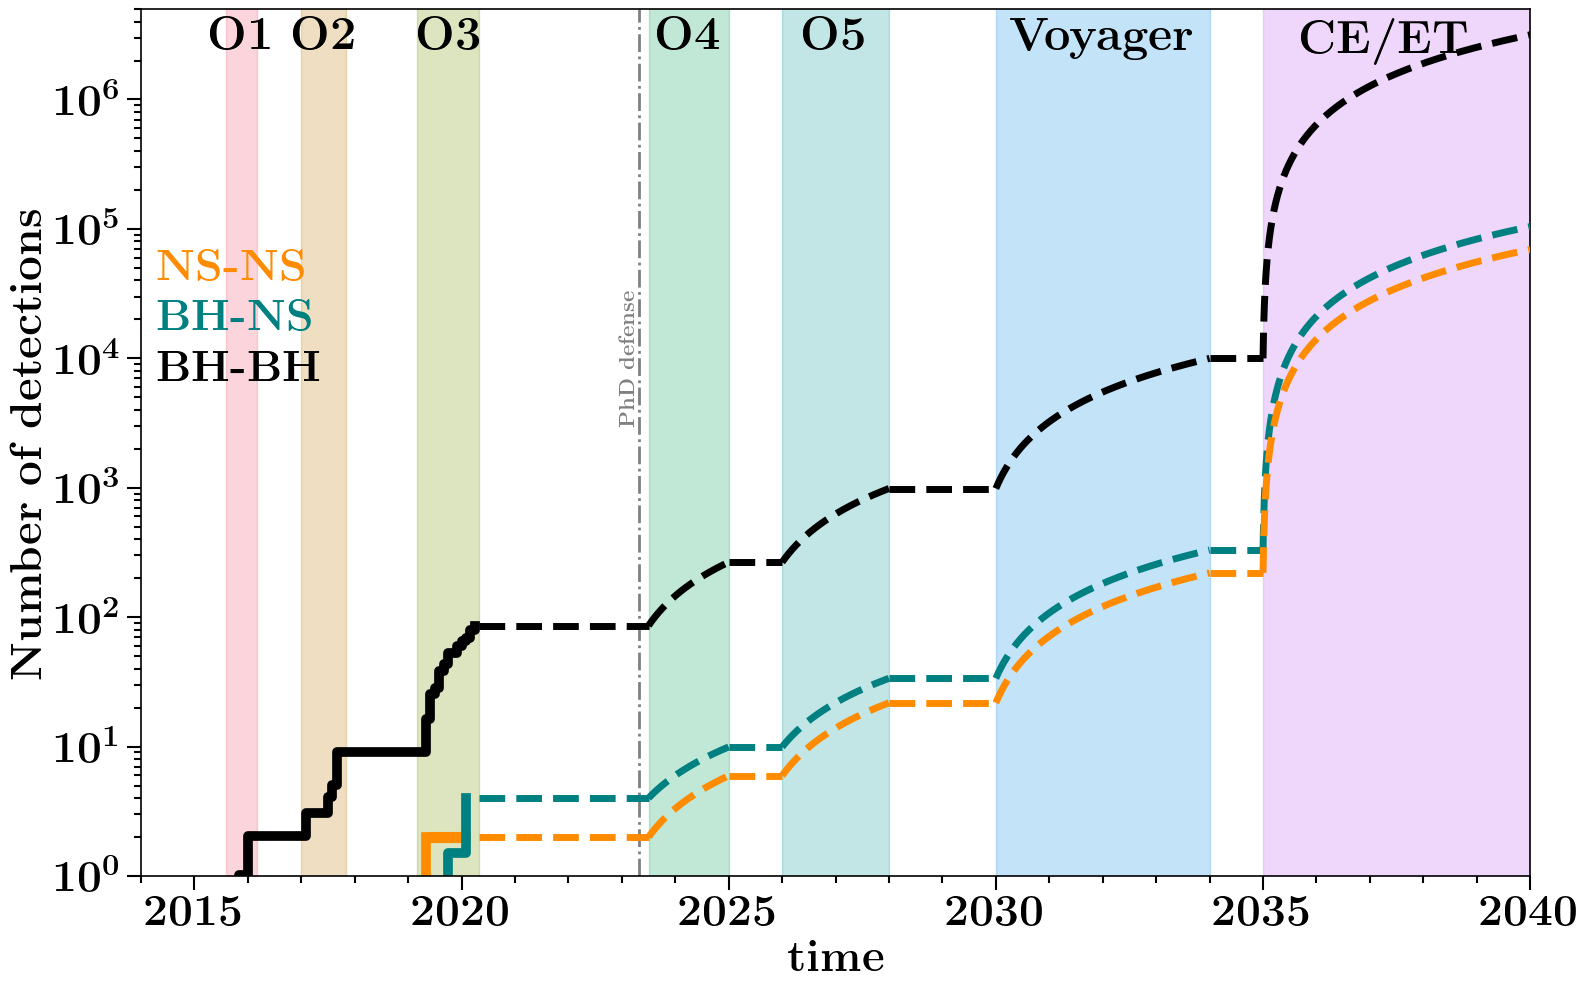

In [115]:
f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))



O1begin = 2015+((7)/12) 
O1end = 2016 +((2)/12) 
O2begin = 2017 + ((0)/12)
O2end = 2017 + ((10)/12)
O3begin = 2019 + ((2)/12)



ET_CEbegin = 2035
ET_CEend = 2040

all_dates = [O1begin, O1end, O2begin, O2end, O3begin, O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]

DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
DCOcolors = ['k',  'teal', 'darkorange']
detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

for ind_DCO, DCOdetections in enumerate(detectionlist):
    cumhist(data=np.asarray(DCOdetections), c=DCOcolors[ind_DCO], lw=7)


for ind_d, line in enumerate(dates[:-1]):
    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
    
    for ind_DCO, DCOlist in enumerate(DCOnumberslist):
        y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
        axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
        
        
    
## fix BNS disconecction due to no detections 
xx = np.linspace(2019.4, 2020.5, 10)
yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
axe.plot(xx, yy, c=DCOcolors[2], lw=8, ls='--', zorder=1)
        
# fill between detector runs
for ind_d, line in enumerate(all_dates[:-1]):
    if (ind_d%2)==0:
        axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.001, 0.001], y2=[1E8,1E8], alpha=0.3, color=colors[ind_d], zorder=0)
    

    

# # print line today 
# x_today = np.linspace(today, today, 100)
# y_today = np.linspace(1, 5*1E6, 100)
# axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')

# print line PhD defense
# days passed since beginning of year
d0 = date(2023, 1, 1)
d1 = date(2023, 4, 24)
delta = d1 - d0
# find phd day, use -1 to correct for that it starts at 0 
phd_day = 2023  + (delta.days-1)/356.
x_today = np.linspace(phd_day, phd_day, 100)
y_today = np.linspace(1, 5*1E6, 100)
axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
axe.annotate(r'$\textbf{PhD defense}$', (phd_day,1E4),  fontsize=fs-8, rotation=90, ha='right', va='center', color='gray' )

    
axe.set_ylim(1,5*1E6)    
axe.set_yscale('log')

axe.xaxis.set_major_locator(plt.MultipleLocator(5))
axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
axe.set_xlim(2014, 2040)

# plot the GW detector labels in the top
plot_detector_labels(axe=axe)

xlabel =  r'\textbf{time}'
ylabel = r'\textbf{Number of detections}'
axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+8)


# annotate labels for BHBH, BHNS, BNS
axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )



plt.tight_layout()

plt.savefig('./GWcatalogSize.png', dpi=600, transparent=False)
plt.savefig('./GWcatalogSize.pdf', transparent=False) 



plt.show()

## add a line that shows PhD thesis: 

# only observations 

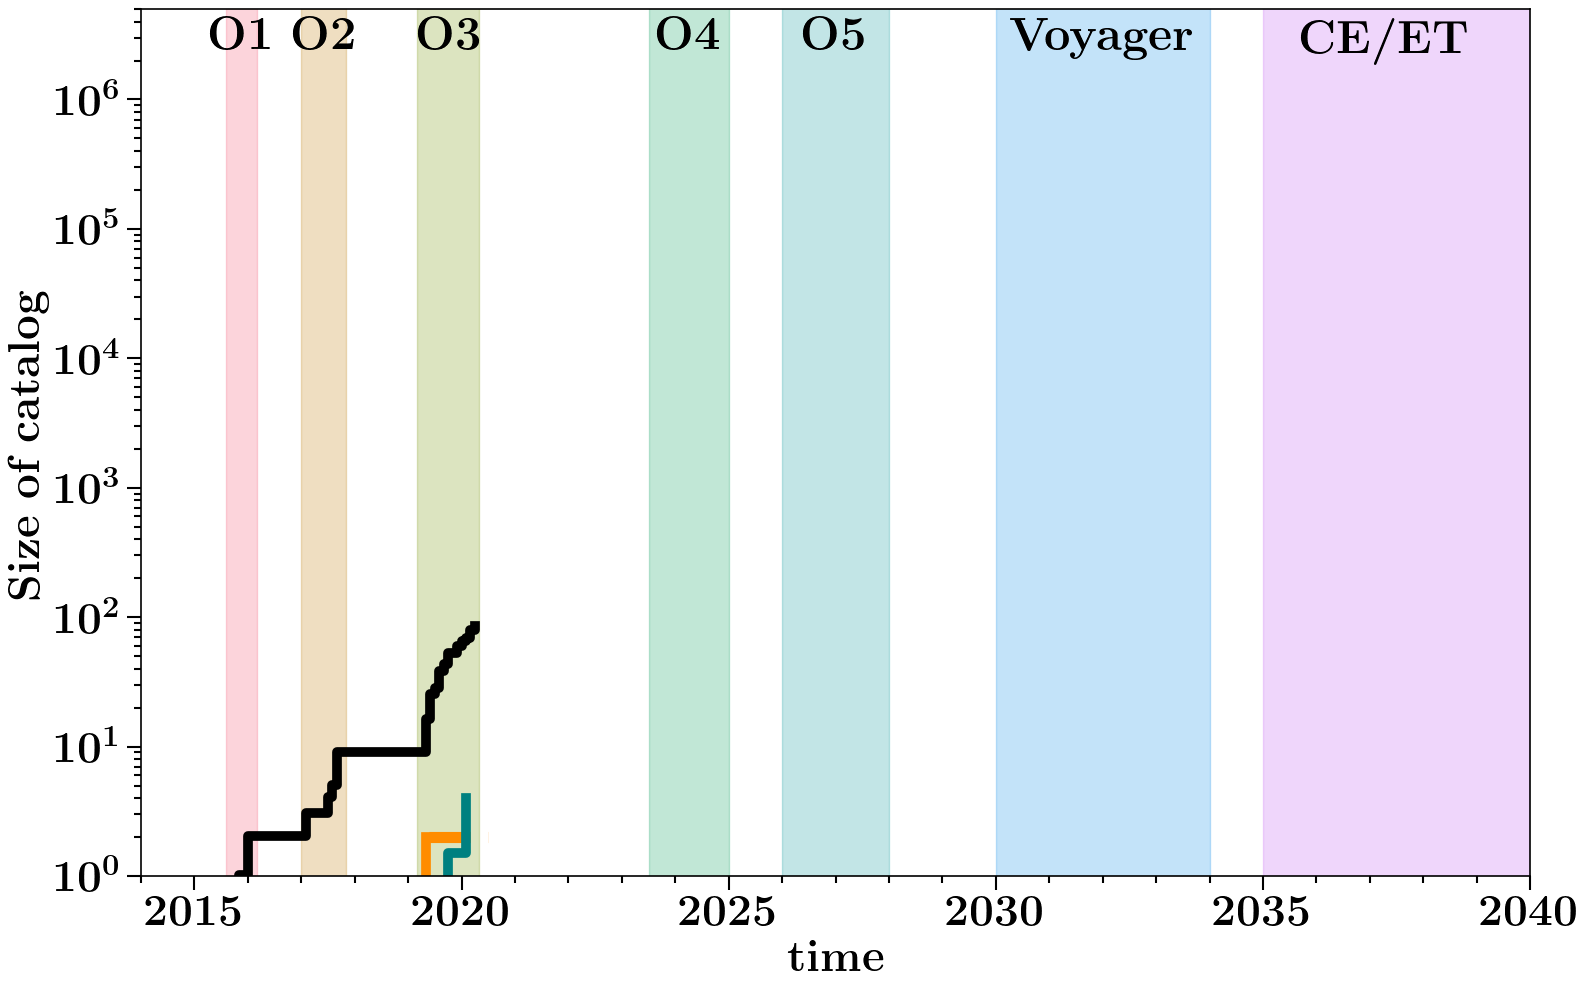

In [67]:
f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))



all_dates = [O1begin, O1end, O2begin, O2end, O3begin, O3end, O4begin, O4end, O5begin, O5end, Voy_begin, Voy_end, ET_CEbegin, ET_CEend]

DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
DCOcolors = ['k',  'teal', 'darkorange']
detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]

for ind_DCO, DCOdetections in enumerate(detectionlist):
    cumhist(data=np.asarray(DCOdetections), c=DCOcolors[ind_DCO], lw=7)

    
## fix BNS disconecction due to no detections 
xx = np.linspace(2019.4, 2020.5, 10)
yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
axe.plot(xx, yy, c=DCOcolors[2], lw=8, ls='--', zorder=1)
        
# fill between detector runs
for ind_d, line in enumerate(all_dates[:-1]):
    if (ind_d%2)==0:
        axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.001, 0.001], y2=[1E8,1E8], alpha=0.3, color=colors[ind_d], zorder=0)
    

    

# print line today 
# x_today = np.linspace(today, today, 100)
# y_today = np.linspace(1, 5*1E6, 100)
# axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')

    
    
axe.set_ylim(1,5*1E6)    
axe.set_yscale('log')

axe.xaxis.set_major_locator(plt.MultipleLocator(5))
axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
axe.set_xlim(2014, 2040)

# plot the GW detector labels in the top
plot_detector_labels(axe=axe)


xlabel =  r'\textbf{time}'
ylabel = r'\textbf{Size of catalog}'
axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=False, fontsize=fs+8)


plt.tight_layout()

plt.savefig('./GWcatalogSize_onlyObservations.png', dpi=600, transparent=False)
# plt.savefig('./GWcatalogSize_onlyObservations.pdf', transparent=False) 



plt.show()

# make plots for movie

In [116]:
def cumhist_stop_year(data, reverse=False, mark=None, ax=None, stop_year=2024, **kwargs):
    """
    Plot a cumulative histogram of `data`, optionally with certain indices marked with an x.

    Parameters
    ----------
    data : array-like
        Data to include in the histogram
    reverse : bool, optional
        If False (default), the histogram increases with increasing `data`. If True, it decreases with increasing `data`
    mark : array-like, optional
        An array of indices to mark with an x
    ax : matplotlib.pyplot.axes, optional
        Axis on which to plot the confusion matrix. Default: current axis.
    kwargs : dict, optional
        Keyword arguments to be passed to `matplotlib.pyplot.step`

    Returns
    -------
    p : list
        The list of `matplotlib.lines.Line2D` objects returned by `matplotlib.pyplot.step`
    """
    
    if mark is None:
        mark = np.zeros(len(data), bool)
    if ax is None:
        ax = plt.gca()
    i = np.argsort(data)
    x = data[i]
    
    # only plot until given stop_year value
    mask_stop_year = data[i]< stop_year
    mark = mark[i]
    
    if np.sum(mask_stop_year)>=1:
#         x_temp = np.append([0], x[mask_stop_year])
        x = np.append(x[mask_stop_year], x[mask_stop_year][-1])
        y = np.linspace(0., x.size-1, x.size) 
        if reverse:
            y = y[::-1]
            
        ax.step(x, y, **kwargs)
    #     ax.scatter(data[i][mark][mask_stop_year], (y[:-1] + 0.5 * np.diff(y))[mark][mask_stop_year], marker='x')
        y_max = y[-1] 
    else:
        y_max=0
    
    return y_max
 




# Main code: make a loop of images to construct a movie / gif 

In [117]:

DCOnumberslist = [numbers_BBH, numbers_BHNS, numbers_BNS]
DCOcolors = ['k',  'teal', 'darkorange']
detectionlist = [strptime_BBHs,  strptime_BHNSs,  strptime_BNSs]



total = 200 
for ind_sy, stop_year in enumerate(np.linspace(2015, 2040, total)):
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


    print('at figure %s out of %s. Stopping this plot at year %s'%(ind_sy+1, total, stop_year))
    y_max_all = []
    
    for ind_DCO, DCOdetections in enumerate(detectionlist):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO], lw=7, stop_year=stop_year)
        y_max_all.append(y_max)


    mask_stop_year = np.asarray(dates[:-1])< stop_year

    if np.sum(mask_stop_year)>=1:
        items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
        for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
            

            for ind_DCO, DCOlist in enumerate(DCOnumberslist):
                
                # if we are only plotting the partial line, because we stop plot before end of line
                # then calculate the slope, and the line begin and end points
                if ind_d+1==items_ind:
                    x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)
                # otherwise just plot the whole line 
                else:
                    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
                
                mask_dates_before_today = (x_<=today)

                axe.plot(x_[mask_dates_before_today], y_[mask_dates_before_today], c=DCOcolors[ind_DCO], lw=7, ls='-', zorder=10)
                axe.plot(x_, y_, c=DCOcolors[ind_DCO], lw=5, ls='--', zorder=10)
                
                y_max_all.append(y_[-1])


        ## fix BNS disconecction due to no detections 
        xx = np.linspace(2019.4, 2020.5, 10)
        yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[2], lw=7, ls='-', zorder=1)
        
        ## fix BHNS disconecction due to no detections 
        xx = np.linspace(2020.2, 2020.5, 10)
        yy = np.linspace(numbers_BHNS[0], numbers_BHNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[1], lw=7, ls='-', zorder=1)
      
        
    # update the max y-value, to scale the y-axis later 
    maxx_ = np.max(y_max_all)
    max_yvalue = np.max([5, maxx_])


    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[1.5*max_yvalue,1.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)

    ###### SHOW TODAY ########
    # uncomment the following four lines if you want to print a vertical line that shows where "today" is  
#     x_today = np.linspace(today, today, 100)
#     y_today = np.linspace(0, 5*1E6, 100)
#     axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')
#     axe.annotate(r'$\textbf{Today}$', (today,0.6), xycoords=('data','figure fraction'),  fontsize=fs-3, rotation=90, ha='right', va='center', color='gray' )
    ################

    axe.set_ylim(0,1.1*max_yvalue)    
    if stop_year<=2035:
        axe.yaxis.set_major_formatter('{x:,.0f}')
    else:
        axe.yaxis.set_major_formatter('{x:2,.0f}')

    # set up axis ticks 
    axe.xaxis.set_major_locator(plt.MultipleLocator(5))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2040)

    # plot the GW detector labels in the top
    plot_detector_labels(axe=axe)
    
    xlabel =  r'\textbf{time}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)

    # annotate labels for BHBH, BHNS, BNS
    axe.annotate(r'$\textbf{BH-BH}$', (2014.3,0.6), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[0] )
    axe.annotate(r'$\textbf{BH-NS}$', (2014.3,0.65), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[1] )
    axe.annotate(r'$\textbf{NS-NS}$', (2014.3,0.7), xycoords=('data','figure fraction'),  fontsize=fs+8, rotation=0, ha='left', va='bottom', color=DCOcolors[2] )
    
    # add y-label, have to use annotate since otherwise alignment between frames is messed up 
    axe.annotate(r'$\#\textbf{Events}$', (0.012,0.85), xycoords=('figure fraction','figure fraction'),  fontsize=fs+6, rotation=0, ha='left', va='center', color='k' )
#     ylabel = r'\textbf{Number of detections}' # original ylabel name         

    # add credits 
    axe.annotate(r'$\copyright \textbf{Floor Broekgaarden}$', (0.899,0.109), xycoords=('figure fraction','figure fraction'),  fontsize=fs-6, rotation=0, ha='right', va='bottom', color='k' )

    # save to directory for making movie later. 
    plt.savefig('./GWcatalogMovie/GWcatalogSize_%s.png'%ind_sy, dpi=100, transparent=False)
#     plt.show() # this will create a *lot* of figures 
    plt.close()



at figure 1 out of 200. Stopping this plot at year 2015.0
at figure 2 out of 200. Stopping this plot at year 2015.1256281407036
at figure 3 out of 200. Stopping this plot at year 2015.251256281407
at figure 4 out of 200. Stopping this plot at year 2015.3768844221106
at figure 5 out of 200. Stopping this plot at year 2015.502512562814
at figure 6 out of 200. Stopping this plot at year 2015.6281407035176
at figure 7 out of 200. Stopping this plot at year 2015.7537688442212
at figure 8 out of 200. Stopping this plot at year 2015.8793969849246
at figure 9 out of 200. Stopping this plot at year 2016.0050251256282
at figure 10 out of 200. Stopping this plot at year 2016.1306532663316
at figure 11 out of 200. Stopping this plot at year 2016.2562814070352
at figure 12 out of 200. Stopping this plot at year 2016.3819095477386
at figure 13 out of 200. Stopping this plot at year 2016.5075376884422
at figure 14 out of 200. Stopping this plot at year 2016.6331658291458
at figure 15 out of 200. Stop

at figure 117 out of 200. Stopping this plot at year 2029.572864321608
at figure 118 out of 200. Stopping this plot at year 2029.6984924623116
at figure 119 out of 200. Stopping this plot at year 2029.824120603015
at figure 120 out of 200. Stopping this plot at year 2029.9497487437186
at figure 121 out of 200. Stopping this plot at year 2030.0753768844222
at figure 122 out of 200. Stopping this plot at year 2030.2010050251256
at figure 123 out of 200. Stopping this plot at year 2030.3266331658292
at figure 124 out of 200. Stopping this plot at year 2030.4522613065326
at figure 125 out of 200. Stopping this plot at year 2030.5778894472362
at figure 126 out of 200. Stopping this plot at year 2030.7035175879396
at figure 127 out of 200. Stopping this plot at year 2030.8291457286432
at figure 128 out of 200. Stopping this plot at year 2030.9547738693468
at figure 129 out of 200. Stopping this plot at year 2031.0804020100502
at figure 130 out of 200. Stopping this plot at year 2031.20603015

In [ ]:
## Steps to make movie: 
# adjust the python script makeMovie.py to point to your directory with GWcatalog images. (here it is /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie)
# optional: you can also change the speed/time/number of frames and the name of the movie etc. 
# run the following code:

!python3 makeMovie.py



Moviepy - Building video /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie/movie_GWcatalogSize.mp4.
Moviepy - Writing video /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie/movie_GWcatalogSize.mp4

Moviepy - Done !                                                                
Moviepy - video ready /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie/movie_GWcatalogSize.mp4
done
Moviepy - Building video /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie/movie_GWcatalogSize_log.mp4.
Moviepy - Writing video /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie/movie_GWcatalogSize_log.mp4

Moviepy - Done !                                                                
Moviepy - video ready /Users/floorbroekgaarden/Projects/GitHub/Othercode/GWcatalogMovie/movie_GWcatalogSize_log.mp4


## Extra 

# Make extra plot panels that ZOOM in onto BNS and BHNS (optional) 

In [26]:


for ind_sy, stop_year in enumerate(np.linspace(2035, 2040, 10)):
    f, axe= plt.subplots(ncols=1,nrows=1,figsize=(16,10))


    print('at %s out of 50. Stopping plot at year %s'%(ind_sy+1, stop_year))
    y_max_all = []
    print()
    # skip BBH
    for ind_DCO, DCOdetections in enumerate(detectionlist[1:]):
        y_max = cumhist_stop_year(data=np.asarray(DCOdetections), ax=axe, c=DCOcolors[ind_DCO+1], lw=6, stop_year=stop_year)
        y_max_all.append(y_max)


    mask_stop_year = np.asarray(dates[:-1])< stop_year

    if np.sum(mask_stop_year)>=1:
        items_ind = len(np.asarray(dates[:-1])[mask_stop_year])
        for ind_d, line in enumerate(np.asarray(dates[:-1])[mask_stop_year]):
            
            # skip BBH 
            for ind_DCO, DCOlist in enumerate(DCOnumberslist[1:]):
                
                
                if ind_d+1==items_ind:
                    x_ = np.linspace(dates[ind_d], stop_year, 1000)
                    dy_rate = (DCOlist[ind_d+1]-DCOlist[ind_d]) / (dates[ind_d+1]-dates[ind_d]) 
                    dy = dy_rate * (stop_year-dates[ind_d])
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d]+dy, 1000)

                else:
                    x_ = np.linspace(dates[ind_d], dates[ind_d+1], 1000)
                    y_ = np.linspace(DCOlist[ind_d], DCOlist[ind_d+1], 1000)
                
                axe.plot(x_, y_, c=DCOcolors[ind_DCO+1], lw=8, ls='--', zorder=10)
                y_max_all.append(y_[-1])

        ## fix BNS disconecction due to no detections 
        xx = np.linspace(2019.4, 2020.5, 10)
        yy = np.linspace(numbers_BNS[0], numbers_BNS[0], 10)
        axe.plot(xx, yy, c=DCOcolors[2], lw=8, ls='--', zorder=1)
        
        
        
#     print('max', np.max(y_max_all))   
    maxx_ = np.max(y_max_all)
    max_yvalue = np.max([5, maxx_])
    print(max_yvalue)

    # fill between detector runs
    for ind_d, line in enumerate(all_dates[:-1]):
        if (ind_d%2)==0:
            axe.fill_between(x=[all_dates[ind_d], all_dates[ind_d+1]], y1=[0.00, 0.00], y2=[1.5*max_yvalue,1.5*max_yvalue], alpha=0.3, color=colors[ind_d], zorder=0)


    # print line today 
    # x_today = np.linspace(today, today, 100)
    # y_today = np.linspace(1, 5*1E6, 100)
    # axe.plot(x_today, y_today, lw=2, ls='-.', color='gray')


    axe.set_ylim(0,1.1*max_yvalue)    
    if stop_year<=2035:
        axe.yaxis.set_major_formatter('{x:,.0f}')
    else:
        axe.yaxis.set_major_formatter('{x:2,.0f}')

        
    axe.xaxis.set_major_locator(plt.MultipleLocator(5))
    axe.xaxis.set_minor_locator(plt.MultipleLocator(1))
    axe.set_xlim(2014, 2040)

    # plot the GW detector labels in the top
    plot_detector_labels(axe=axe)

    xlabel =  r'\textbf{time}'
    ylabel = r'\textbf{Size of catalog}'
    axe = layoutAxes(axe, nameX=xlabel, nameY=None, setMinor=False, fontsize=fs+8)
    

#     plt.tight_layout()

    plt.savefig('./GWcatalogMovie/GWcatalogSize_%s.png'%int(ind_sy+200), dpi=100, transparent=False)
#     plt.savefig('./GWcatalogMovie/GWcatalogSize_%s.pdf'%ind_sy, transparent=False) 
#     plt.show()
    plt.close()

at 1 out of 50. Stopping plot at year 2035.0

1264.0
at 2 out of 50. Stopping plot at year 2035.5555555555557

14597.333333335759
at 3 out of 50. Stopping plot at year 2036.111111111111

27930.66666666606
at 4 out of 50. Stopping plot at year 2036.6666666666667

41264.00000000182
at 5 out of 50. Stopping plot at year 2037.2222222222222

54597.33333333212
at 6 out of 50. Stopping plot at year 2037.7777777777778

67930.66666666788
at 7 out of 50. Stopping plot at year 2038.3333333333333

81263.99999999818
at 8 out of 50. Stopping plot at year 2038.888888888889

94597.33333333394
at 9 out of 50. Stopping plot at year 2039.4444444444443

107930.66666666424
at 10 out of 50. Stopping plot at year 2040.0

121264.0
